# BAIRD COUNTER EXAMPLE - GTD,GTD2,TDC,TD

In [1]:
import numpy as np
from matplotlib import pyplot as plt

/Users/Greta/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [27]:
from scipy.stats import rv_discrete

In [241]:
def behavior_policy(s,actions,p_actions): 
    # proba solid 1/7 and proba dashed = 6/7
    x = [1,2]
    a = int(rv_discrete(values=(x,p_actions)).rvs(size=1))
    return actions[a-1]
    
def target_policy(s) : 
    a = 'solid'
    return a

def new_state(s,a,term_s,states) : 
    # terminal state with proba 0.01 and normal next state with proba 0.99
    x = [1,2]
    px = [0.01,0.99]
    m = int(rv_discrete(values=(x,px)).rvs(size=1))
    
    if a == 'dashed' : 
        new_s = np.random.choice(states[:6])
    if a == 'solid' : 
        new_s = 6
        
    if m == 1: # ie terminal state
        new_s = term_s
    
    return new_s

def phi_states(s,new_s,dim_features,Phi,term_state) : 
    fi = Phi[s]
    fi_prime = np.zeros((dim_features,))
    if new_s != term_state :
        fi_prime = Phi[new_s]
    return fi,fi_prime
        
def one_episode_td(alpha_td,states,actions,p_actions,term_state,dim_features,theta_o,discount,Phi,Pi,P) : 
    theta = np.copy(theta_o)
    s = np.random.choice(states)
    end = False
    while end is False : 
        # take action a according to the behaviour policy and observe reward and new_state
        a = behavior_policy(s,actions,p_actions)
        r = 0
        new_s = new_state(s,a,term_state,states)
        fi,fi_prime = phi_states(s,new_s,dim_features,Phi,term_state)

        # get the importance ratio
        rho = 0. # pi(dashed|.) = 0
        if a == 'solid' : 
            rho = 1./(1./7.)

        # update the value learning backup
        delt = discount * np.dot(theta.T,fi_prime) - np.dot(theta.T,fi)
        theta = theta + alpha_td * rho * delt * fi

        # go to next state
        if new_s == term_state : 
            end = True
        s = new_s
    
    # compute rmspbe
    rmspbe = compute_rmspbe(discount,theta,Phi,Pi,P)
        
    return theta,rmspbe

def one_episode(algo,eta,w_o,alpha_gtd,states,actions,p_actions,term_state,dim_features,theta_o,discount,Phi,Pi,P) :      
    theta = np.copy(theta_o)
    w = np.copy(w_o)
    s = np.random.choice(states)
    end = False
    while end is False : 
        # take action a according to the behaviour policy and observe reward and new_state
        a = behavior_policy(s,actions,p_actions)
        r = 0
        new_s = new_state(s,a,term_state,states)
        fi,fi_prime = phi_states(s,new_s,dim_features,Phi,term_state)

        # get the importance ratio
        rho = 0. # pi(dashed|.) = 0
        if a == 'solid' : 
            rho = 1./(1./7.)
            
        # update values
        delt = discount * np.dot(theta.T,fi_prime) - np.dot(theta.T,fi)
        
        if algo == 'GTD2' : 
            theta = theta + alpha_gtd * rho * (fi - discount * fi_prime) * np.dot(fi,w)
            w = w + alpha_gtd * eta * (rho * delt - np.dot(fi,w)) * fi 

        elif algo == 'TDC' : 
            theta = theta + alpha_gtd * rho * delt * fi - rho * alpha_gtd * discount * fi_prime * np.dot(fi,w)
            w = w + alpha_gtd * eta * (rho * delt - np.dot(fi,w)) * fi                

        elif algo == 'GTD' : 
            theta = theta + alpha_gtd * rho * (fi - discount * fi_prime) * np.dot(fi,w)
            w = w + alpha_gtd * eta * rho * (delt*fi - w)               
            
        # go to next state
        if new_s == term_state : 
            end = True
            
        s = new_s

    # compute rmspbe
    rmspbe = compute_rmspbe(discount,theta,Phi,Pi,P)

    return theta,w,rmspbe
    
def compute_rmspbe(discount,theta,Phi,Pi,P) :
    v = np.dot(Phi,theta)
    pitv = discount*np.dot(P,v)
    mspbe = np.sum((v-pitv)**2)/float(dim_states)
    #mspbe = ((v - discount * Pi.dot(P).dot(v)).T).dot(D).dot((v - discount * Pi.dot(P).dot(v)))
    rmspbe = np.sqrt(mspbe)
    return rmspbe

# Environment

In [246]:
states = range(7)
term_state = 7
actions = ['dashed','solid']
p_actions=[6./7.,1/7.]
dim_states = 7
dim_features = 8

discount = 0.99
alpha_td = 0.001
alpha_gtd = 0.0005
eta = 10
nb_episodes = 100

Phi = np.array([
        [2,0,0,0,0,0,0,1],
        [0,2,0,0,0,0,0,1],
        [0,0,2,0,0,0,0,1],
        [0,0,0,2,0,0,0,1],
        [0,0,0,0,2,0,0,1],
        [0,0,0,0,0,2,0,1],
        [0,0,0,0,0,0,1,2]])

In [247]:
D = np.diag(np.ones((dim_states,))/float(dim_states))
B = np.linalg.inv((Phi.T).dot(D).dot(Phi))
Pi = Phi.dot(B).dot(Phi.T).dot(D)
P_mu = 1./dim_states * np.ones((dim_states,)) - 1./dim_states * np.diag(np.ones((dim_states,)))                                                        
P_pi = np.array([
        [0,0,0,0,0,0,1],
        [0,0,0,0,0,0,1],
        [0,0,0,0,0,0,1],
        [0,0,0,0,0,0,1],
        [0,0,0,0,0,0,1],
        [0,0,0,0,0,0,1],
        [0,0,0,0,0,0,1]])

### Multiple episodes TD

In [248]:
count_episode = 0
theta_o = np.array([1,1,1,1,1,1,10,1])
perf_td = []
thetas = dict()
for i in range(1,9) :
    thetas[i] = []
while count_episode < nb_episodes : 
    theta,rmspbe = one_episode_td(alpha_td,states,actions,p_actions,term_state,dim_features,theta_o,discount,Phi,Pi,P_pi)

    for i in range(8) : 
        thetas[i+1].append(theta[i])
    
    perf_td.append(rmspbe)
    theta_o = theta

    count_episode += 1
    if count_episode % 20 == 0 : 
        print 'episode %s done'%count_episode

episode 20 done
episode 40 done
episode 60 done
episode 80 done
episode 100 done


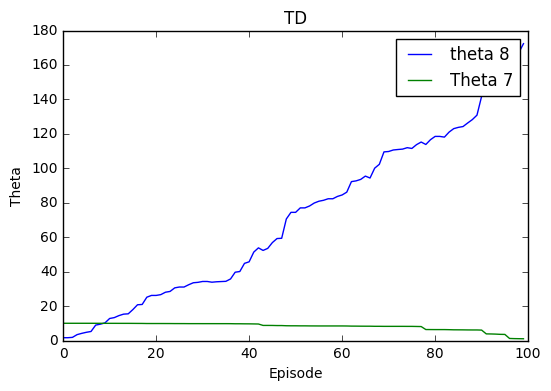

In [250]:
x = range(nb_episodes)
plt.plot(x,thetas[8],label = 'theta 8')
plt.plot(x,thetas[7],label = 'Theta 7')
plt.xlabel('Episode')
plt.ylabel('Theta')
plt.legend()
plt.title('TD')
plt.show()

### Multiple episodes GTD

In [258]:
count_episode = 0
theta_o = np.array([1,1,1,1,1,1,10,1])
perf_gtd = []

w_o = np.zeros((dim_features,))

count_episode = 0

while count_episode < nb_episodes :
    theta,w,rmspbe = one_episode('GTD',eta,w_o,alpha_gtd,states,actions,p_actions,term_state,dim_features,theta_o,discount,Phi,Pi,P_pi)

    theta_o = theta
    w_o = w

    count_episode += 1

    perf_gtd.append(rmspbe)
    if count_episode % 20 == 0 : 
        print 'episode %s done'%count_episode

episode 20 done
episode 40 done
episode 60 done
episode 80 done
episode 100 done


### Multiple episodes GTD2

In [251]:
count_episode = 0
theta_o = np.array([1,1,1,1,1,1,10,1])
perf_gtd2 = []

w_o = np.zeros((dim_features,))

count_episode = 0

while count_episode < nb_episodes :
    theta,w,rmspbe = one_episode('GTD2',eta,w_o,alpha_gtd,states,actions,p_actions,term_state,dim_features,theta_o,discount,Phi,Pi,P_pi)

    theta_o = theta
    w_o = w

    count_episode += 1

    perf_gtd2.append(rmspbe)
    if count_episode % 20 == 0 : 
        print 'episode %s done'%count_episode

episode 20 done
episode 40 done
episode 60 done
episode 80 done
episode 100 done


### Multiple episodes TDC

In [254]:
count_episode = 0
theta_o = np.array([1,1,1,1,1,1,10,1])
perf_tdc = []
w_o = np.zeros((dim_features,))

count_episode = 0

while count_episode < nb_episodes :
    theta,w,rmspbe = one_episode('TDC',eta,w_o,alpha_gtd,states,actions,p_actions,term_state,dim_features,theta_o,discount,Phi,Pi,P_pi)

    theta_o = theta
    w_o = w

    count_episode += 1
    perf_tdc.append(rmspbe)
    if count_episode % 20 == 0 : 
        print 'episode %s done'%count_episode

episode 20 done
episode 40 done
episode 60 done
episode 80 done
episode 100 done


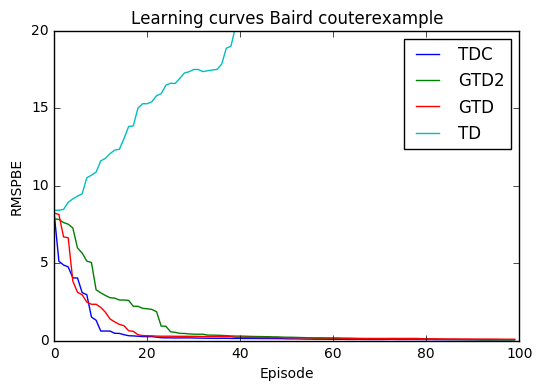

In [261]:
x = range(nb_episodes)
plt.plot(x,perf_tdc,label = 'TDC')
plt.plot(x,perf_gtd2,label = 'GTD2')
plt.plot(x,perf_gtd,label = 'GTD')
plt.plot(x,perf_td,label = 'TD')
plt.xlabel('Episode')
plt.ylabel('RMSPBE')
plt.ylim((0,20))
plt.legend()
plt.title('Learning curves Baird couterexample')
plt.show()